<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Getting Started

Before we can develop networks, we'll need to import the tools we'll be using and get our data.

First, let's get our imports. These are all ones we've used in previous projects, with the possible exception of `datetime`. We'll use that to get the current time and date.

In [2]:
import datetime
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

Let's also the print the versions of the packages we're using. If someone else looks at this, or we come back to it later, we'll know what was working.

In [3]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)

!python --version

torch version :  2.2.2+cu121
torchvision version :  0.17.2+cu121
numpy version :  1.26.3
Python 3.11.0


We'll be working with networks, so we'll want to use GPUs.

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### Loading Data

We'll be working with a new dataset for this project. It will be images, as in the last several projects. This time we'll be looking at medical images.

<div class="alert alert-warning">
    <p>
  <strong>Warning: difference with video</strong>
        </p>
    <p>
  The video associated to this lesson shows the instructor downloading the dataset from GCP. We've modified this project to make that data available without the need of downloading it. You can skip the parts where the instructor downloads and extracts the compressed data.
    </p>
    <p>The resulting directory and data are the same.</p>
</div>

Let's look at a few images to see what we're working with. We'll need a path to our files. They're in the `data_p5/gan_training_images` directory.

**Task 5.2.1:** Create a variables to access the `data_p5` and `data_p5/gan_training_images/` directories. Use `pathlib`.

In [20]:
data_dir = Path('data_p5')
images_dir = data_dir / 'gan_training_images'
print(images_dir)

data_p5/gan_training_images


This code will randomly select and display a few images. We have a collections of MRI scans of brains. We're resizing them to fit them on the screen, so some may look a little squashed.

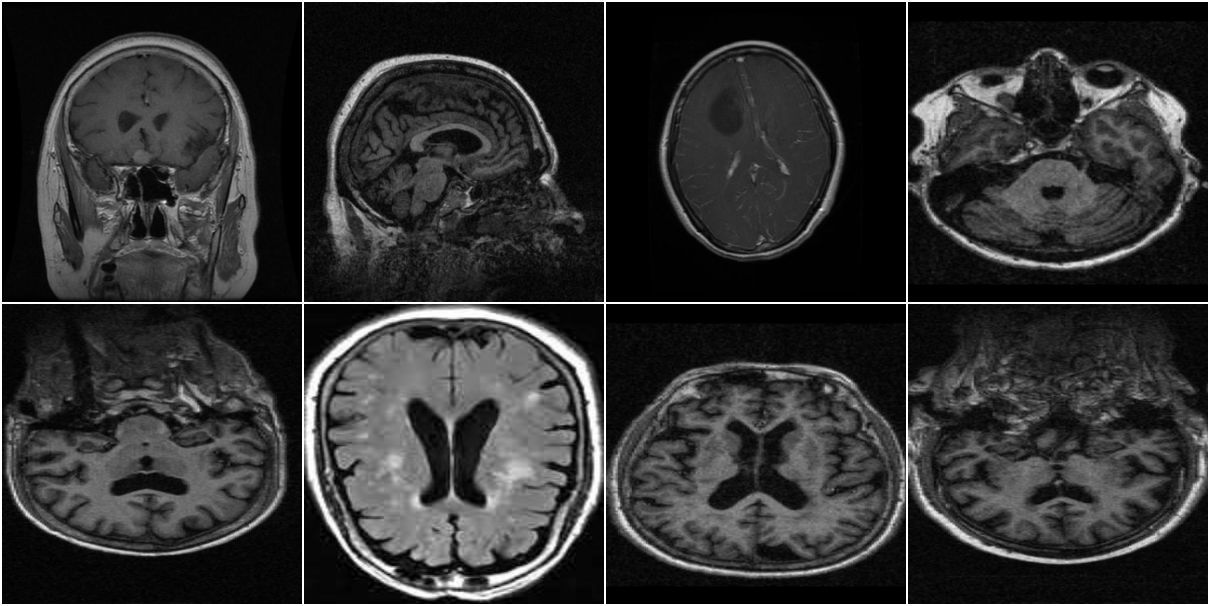

In [21]:
image_list = list(images_dir.glob("*.jpg"))

image_sample = random.sample(image_list, 8)

resize = transforms.Resize((300, 300))
gray = transforms.Grayscale()

images = []
for file in image_sample:
    img = read_image(str(file))
    img = gray(resize(img))
    images.append(img)

real_grid = make_grid(images, nrow=4, pad_value=255.0)
torchvision.transforms.ToPILImage()(real_grid)

We'll need to set these up so PyTorch can access them. This means creating an `ImageFolder`. We'll also need to transform the images as they come in. To keep computations under control, we'll resize the images to $64$ x $64$ and make them grayscale. So we'll need to make the following transformations:

- Convert to grayscale
- Resize to $64$ x $64$
- Convert to tensor

The grayscale conversion reduces us to one color channel.

**Task 5.2.2:** Create the transformations to resize and convert to tensor. The grayscale is already provided. Use the `IMAGE_SIZE` variable when resizing.

In [22]:
IMAGE_SIZE = 64

transformations = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64,64)),
        transforms.ToTensor()
    ]
)

transformations

Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

With the directory structure we have, we'll want to create an `ImageFolder` on the `data_dir`. This will read in all of our images into one class (corresponding to the `gan_training_images` directory). This will be fine for us, since we won't be using the class information.

**Task 5.2.3:** Create an `ImageFolder` using our transformations, and a `DataLoader`. Use a batch size of $128$ and make sure to turn on shuffling.

In [26]:
batch_size = 128

dataset = datasets.ImageFolder('data_p5/gan_training_images',transform=transformations)
# dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

# single_batch = next(iter(dataloader))[0]
# print(f"Batches have shape: {single_batch.shape}")

FileNotFoundError: Couldn't find any class folder in data_p5/gan_training_images.

We should be getting $128$ images, with one color channel, of size $64$ x $64$. This gives us a set of "good" medical images - ones that look like the real thing. We'll need these as a reference point when we try to generate "fake" ones.

## Generative Adversarial Networks

To work with generative adversarial networks (GANs), we generally need two networks. One is called the generator. It attempts to make new images. The second is the discriminator. It tries to tell if an image is real or created by the generator. The GAN process pits the two against each other.

### Discriminator

We'll start by creating the discriminator, as it's more familiar. It's an image classifier, similar to what we've made in earlier projects. We'll make a simpler one for this, so it runs a bit faster. Instead of using a convolutional network, we'll flatten our image down to a vector and use standard `Linear` (fully connected) layers. For our activation functions, we'll use `LeakyReLU(0.25)`, except for the final layer. 

We're trying to tell real from fake images. We could think of this as two classes, but really it's only one: if it's not real, it's fake. So we'll produce an output with one value for each image. With only one output, we'll need the `Sigmoid` to get a result between $0$ and $1$, instead of the `SoftMax` we used with multiple classes.

Our network will be:

- Flatten image
- Linear layer with 1024 neurons
- `LeakyReLU(0.25)`
- Linear layer with 512 neurons
- `LeakyReLU(0.25)`
- Linear Layer with 256 neurons
- `LeakyReLU(0.25)`
- Linear layer to produce one output (1 neuron)
- `Sigmoid`

We'll build this with a `Sequential` container as we have done in previous projects. Here are the first few layers to get started.

In [ ]:
discriminator = nn.Sequential()
discriminator.append(nn.Flatten())

# Input images are 1 * 64 * 64 = 4096 pixels after flattening
discriminator.append(nn.Linear(1 * 64 * 64, 1024))
discriminator.append(nn.LeakyReLU(0.25))

So far, we should be getting an output with the shape `[batch_size, 1024]`.

In [ ]:
discriminator(single_batch).shape

**Task 5.2.4:** Add the 512 neuron linear layer, `LeakyReLU`, 256 linear layer, and `LeakyReLU` (in that order).

Make sure the `negative_slope` of the `LeakyReLU` layers have a `0.25` negative slope. If you make a mistake, you might need to recreate from scratch your `discriminator` model. Execute the cell above again.

In [ ]:
# Add linear layer with 512 and Leaky ReLU
# Add linear layer with 256 and Leaky ReLU
discriminator...

discriminator

Let's check the output shape.

In [ ]:
print("Getting results with following shape:")
print(discriminator(single_batch).shape)

This should have given us a result with shape `[batch_size, 256]`. 

<div class="alert alert-info" role="alert">
If you got an error, remember that <tt>append</tt> modifies the network, you may need to restart it from scratch by running the previous few cells.
</div>

Our output will be one value for each image.

**Task 5.2.5:** Add a linear layer with one output (neuron).

In [ ]:
# Add the linear layer with one neuron
discriminator...

print("Getting results with following shape:")
print(discriminator(single_batch).shape)

We should be getting one result per input image now, so a `[batch_size, 1]` tensor. Without an activation function we could be getting any value for output. We want a value between $0$ and $1$. Let's put on the `Sigmoid` and see what we now have.

In [ ]:
discriminator.append(nn.Sigmoid())

That's the discriminator. We also need a generator.

<div class="alert alert-info" role="alert">
If you're wondering if a convolutional neural network would do a better job here, the answer is almost certainly yes. We went with the flattened image and fully connected route for speed and simplicity. We also wanted symmetry with the generator we're about to create using fully connected layers. That isn't necessary, it's completely fine to have the discriminator and generator made out of different pieces. Networks are "black boxes", they can't see inside each other. And you <i>can</i> make a generator using a version of convolutions, but it's more complicated.
</div>

### Generator

The generator is a new structure for us. It will need to create new images out of nothing. How can we do this?

We'll start by creating some random numbers. We don't want to create the entire image randomly, since that would just give us noise. Instead, we'll create a smaller _noise vector_, basically an array of random numbers of some size. We'll pick $100$ here, as a reasonable compromise size. 

We'll then run a process similar to our discriminator in reverse. Instead of getting progressively smaller numbers of neurons per layer, we'll get progressively more, until we have the $4096$ we need for a $1$ x $64$ x $64$ image. We'll reshape that into an image, and output it.

We'll break our generator into three _upsampling_ stages. In each of these we'll expand the size of our vector, with a `Linear` layer with more outputs than inputs. We'll turn off the `bias` term, that's the $b$ in the linear neuron equation:

$$\mathrm{out} = \sum_i w_i\cdot \mathrm{input}_i + b$$

We'll then have a `BatchNorm1d`. This acts to speed up the training and make it go smoother. We'll follow that up with a `LeakyReLU(0.25)` activation function, the same as the discriminator. Here's the first upsampling stage.

In [ ]:
noise_size = 100
first_stage_size = 256

generator = nn.Sequential()
generator.append(nn.Linear(noise_size, first_stage_size, bias=False))

# The batch norm doesn't change the shape, but needs the number of inputs
# The 0.8 adjusts its behavior, we'll use the same value for all stages
generator.append(nn.BatchNorm1d(first_stage_size, 0.8))
generator.append(nn.LeakyReLU(0.25))

This takes our $100$ random numbers and gives us $256$. Let's get a batch of random numbers to verify.

In [ ]:
# Create a batch of random numbers
random_number_sample = torch.randn(batch_size, noise_size)
random_number_sample.shape

**Task 5.2.6:** Run the current `generator` with just the first upsampling on the `random_number_sample`.

In [ ]:
first_upscale = ...

print(f"After first upscale: {first_upscale.shape}")

Our second upsampling will look just like our first, except this time we'll go from $256$ inputs to $512$ outputs.

**Task 5.2.7:** Add the second upsampling stage of a linear layer, `BatchNorm1d`, and `LeakyReLU` to the `generator`. Remember we're setting `bias=False` in the `Linear` layer.

In [ ]:
second_stage_size = ...

# Add second upsampling stage
generator...


Let's double check the output shape - it should be a `[batch_size, 512]`.

In [ ]:
generator(random_number_sample).shape

We'll do a third upsampling stage to double the number of outputs again. This will take it from $512$ to $1024$.

**Task 5.2.8:** Add the third upsampling stage of a linear layer, `BatchNorm1d`, and `LeakyReLU` to the `generator`. Remember we're setting `bias=False` in the `Linear` layer.

In [ ]:
third_stage_size = ...

# Add third upsampling stage
generator...

Let's double check the output shape - it should be a `[batch_size, 1024]`.

In [ ]:
generator(random_number_sample).shape

Our target output size is $4096$, so we could double two more times. Instead we'll do that in a single stage, to keep the network size under control.

**Task 5.2.9:** Add the final `Linear` layer, going from the previous layer to $4096$. Remember we're setting `bias=False` in the `Linear` layer.

In [ ]:
# Add the final linear layer
generator...

generator

This will be our final stage, so we'll use a different activation function. We aren't restricted to a classification output like the discriminator was, but we need something that has image-like values. We could use the `Sigmoid` again, but instead we'll use the `Tanh` this time. 

We'll also need to reshape our $4096$ to an image. We'll use `Unflatten` here, the opposite of `Flatten`. It takes a single dimension and expands it to whatever shape we ask for. We'll tell it to take the second dimension of the tensor (the $4096$ rather than the batch size) and expand it to a `[1, 64, 64]`. Recall that Python is zero-based indexing, so the second dimension is called $1$.

In [ ]:
generator.append(nn.Tanh())
generator.append(nn.Unflatten(1, [1, 64, 64]))

One last check - we should now be getting batches of images! They should be `[batch_size, 1, 64, 64]`.

**Task 5.2.10:** Run the `generator` on the `random_number_sample` and get the shape of its output.

In [ ]:
generator_output = ...
output_shape = ...

print(f"Generator output shape: {output_shape}")

That's our generator!

Right now it's untrained, so it will create images that are just noise. Here's what one looks like.

In [ ]:
plt.imshow(generator_output[0, 0].detach(), cmap="gray")
plt.axis("off");

Now it's time to train.

<div class="alert alert-info" role="alert">
You don't have to double the output size at each stage. You could do more or less, the important thing is the number increases. Doubling is common because it's convenient to work with. If you make your own, you can play with this process. You could also use a different activation function, or see what happens if the <tt>Linear</tt> layers have bias, or leave off the batch norm. You'll get different results, but they may be better than ours or worse. We make no claim that this is the best network. In fact it's not, as we'll see when we generate images.
</div>

## Training the GAN System

Training will work a bit differently than in earlier projects. We aren't training a single network, but instead we're training two networks against each other. We can still use the same tools, but we'll need to organize things differently. We also don't have already labeled data, we'll have to mark our images as real or fake (we'll use the label $1$ for real and $0$ for fake).

Let's start setting this up.

### Setup

Because this training process is more complicated, it's going to take a while. We'll want to set up some version of checkpointing. We'll keep it simple and save the model each epoch, regardless of loss values. Let's make a separate directory for each time we run this, we can label them with the current date and time. We'll use `datetime` to get the time and format it in a readable way.

In [ ]:
# Gets the time in the order year-month-day_hour-minute-second
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
now

**Task 5.2.11:** Create a path variable to the directory `runs`, and a subdirectory named using the `now` variable. Create those directories. Use `pathlib`.

In [ ]:
runs_dir = ...
now_dir = ...

# Create the directories with mkdir

print(f'directory "{now_dir}" exists: {now_dir.exists()}')

<div class="alert alert-info" role="alert">
It's very likely that the time you're seeing doesn't match your clock. This is for two reasons. One is that it's looking at the time for the server, which is probably in a different time zone than you are. The other is that it may be using UTC rather than any local time zone.
</div>

To train the models, we'll need optimizers. The discriminator and generator will need separate ones, since they're going to have different goals. We want the discriminator to get better at telling real from fake, and the generator to get better at fooling the discriminator. So an optimization step for one makes the other one worse!

Thankfully, we can use the same _kind_ of optimizer for both, with the same settings. We'll use `AdamW`, a modified version of the `Adam` that we've been using. We'll also adjust two of its settings: `lr` and `betas`. We found that modifying these gave us better training results.

**Task 5.2.12:** Fill in the missing parameters for the discriminator and generator optimizers.

In [ ]:
lr = 0.0002
betas = (0.5, 0.999)

disc_opt = torch.optim.AdamW(params=..., lr=lr, betas=betas)
gen_opt = torch.optim.AdamW(params=..., lr=lr, betas=betas)

n_disc_pars = len(disc_opt.param_groups[0]["params"])
n_gen_pars = len(gen_opt.param_groups[0]["params"])

print(f"disc_opt sees {n_disc_pars} parameters, should be 8")
print(f"get_opt sees {n_gen_pars} parameters, should be 10")

We'll also need a loss function. We'll use the same one for both, the `BCELoss`. This is the binary cross entropy, very similar to the cross entropy we've used in previous projects. The biggest differences are that this is only expecting one class, and that it expects predictions that have been run through the `Sigmoid` function. If we hadn't included the `Sigmoid` to get predictions between $0$ and $1$, we'd need the `BCEWithLogitsLoss` instead.

In [ ]:
loss_function = nn.BCELoss()

As our last setup step, let's make sure our models are on the GPU.

**Task 5.2.13:** Move the discriminator and the generator to `device`.

In [ ]:
# discriminator to device

# generator to device

disc_dev = next(generator.parameters()).device.type
gen_dev = next(generator.parameters()).device.type

print(f"Discriminator on {disc_dev}")
print(f"Generator on {gen_dev}")

### Generating Images

We're going to need to have the generator create images at each step in the training. It's important that these are new images, based on a new random number draw. If we used the same random number, the model would only ever be able to create one set of images! We want it to create an endless supply, that's the point. Since we'll be doing that a lot, let's make a function for it.

**Task 5.2.14:** Fill in the missing parts of the function. You can use the same code we used when we were testing the generator earlier.

In [ ]:
def make_random_images(batch_size, generator=generator):
    # Create a batch of random numbers

    random_number_sample = random_number_sample.to(device)
    generator.eval()

    # Run the generator on the random numbers

    return generator_output

In [ ]:
# Test run
sample_images = make_random_images(batch_size, generator)
print(f"Output shape: {sample_images.shape}")

We should be getting batches of images, with shape `[128, 1, 64, 64]` since we have `batch_size` of $128$. They're noise right now, but we'll want to print a sample as we train to see how the model is improving. This function displays them on screen.

In [ ]:
def display_images(image_tensor, n_to_display=6):
    grid = make_grid(image_tensor[:n_to_display], nrow=6, normalize=True)
    img_out = transforms.ToPILImage()(grid)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(img_out)
    plt.axis("off")
    plt.show()

Let's see how they look right at the start.

In [ ]:
display_images(sample_images)

### Training Step

As usual, our training will be a number of epochs. Each epoch is one pass through the real data, broken into minibatches. So our training process will be a loop over epochs, and each of those loops is a loop over batches. Let's call the processing of one batch a batch step.

Each batch step in our training will follow this pattern:

- Take a batch of real images, label them all $1$
- Train the discriminator one step on the real images
- Have the generator create a batch of fake images, label them all $0$
- Train the discriminator one step on the fake images
- Get the predictions of the discriminator on the fake images
- Train the generator to trick the discriminator

To break the code up a bit, let's make a function to perform one batch step. We can then loop over that.

In [ ]:
def perform_batch_step(
    discriminator,
    generator,
    real_data_batch,
    loss_function,
    disc_opt,
    gen_opt,
    device=device,
):
    """Perform a single batch step"""

    # Set real and fake labels
    real_label_val = 1.0
    fake_label_val = 0.0

    # Send real data to device
    # This pulls out just the images, we'll make our own label
    real_images = real_data_batch[0].to(device)

    # Create labels: all 1.0 for real data
    actual_batch_size = real_images.size(0)
    real_label = torch.full((actual_batch_size, 1), real_label_val, device=device)

    # Get the derivative for the real images
    disc_opt.zero_grad()
    real_output = discriminator(real_images)
    real_loss = loss_function(real_output, real_label)
    real_loss.backward()

    # Generate fake images using the generator
    fake_images = make_random_images(actual_batch_size, generator)
    # label all fake images as 0.0
    fake_label = torch.full((actual_batch_size, 1), fake_label_val, device=device)

    # Get the derivative for the fake images
    fake_output = discriminator(fake_images.detach())
    fake_loss = loss_function(fake_output, fake_label)
    fake_loss.backward()

    # Discriminator total loss
    disc_loss = real_loss.item() + fake_loss.item()

    # Train the discriminator
    disc_opt.step()

    # Get derivative for the generator
    # We're adjusting the generator to make the
    # discriminator think fake images are real
    gen_opt.zero_grad()
    trick_output = discriminator(fake_images)
    trick_loss = loss_function(trick_output, real_label)
    trick_loss.backward()

    # Train the generator
    gen_opt.step()

    # Generator loss
    gen_loss = trick_loss.item()

    # Return discriminator loss and generator loss for logging
    return gen_loss, disc_loss

With that in hand, we can now look at a whole epoch. At each epoch we will:

- Loop over our data loader
- For each batch, run it through the `perform_batch_step` function
- Checkpoint both the discriminator and the generator
- Generate a batch of images to see the model's progress
- Print a summary of the model's losses and display the images

Let's make a function we can call to checkpoint. We'll get the state dictionary of the discriminator and generator, and save them to files named `discriminator_{epoch}.pth` and `generator_{epoch}.pth`, respectively. This will give us a file for each epoch, which we can load if something goes wrong or when the training is done.

**Task 5.2.15:** Fill in the missing pieces in the `save_models` function to save the discriminator and generator state dictionaries.

In [ ]:
def save_models(discriminator, generator, epoch, directory):
    # Get discriminator state dictionary
    disc_state_dict = ...

    disc_filename = directory / f"discriminator_{epoch}.pth"

    # Save discriminator save dictionary to `disc_filename`

    # Get generator state dictionary
    gen_state_dict = ...

    gen_filename = directory / f"generator_{epoch}.pth"

    # Save generator save dictionary to `gen_filename`

Let's call it to save the state before we start training. This isn't necessary, since it's just random right now, but it will help us make sure it works. We'll give it an epoch number of `untrained` to make it clear it's not part of the training process.

In [ ]:
save_models(discriminator, generator, "untrained", now_dir)

print(f"Files in {now_dir}")
for filename in now_dir.glob("*"):
    print("\t", filename)

### Training Over Epochs

We're ready to put things together for an epoch of training. We'll train on our real image data loader, checkpoint our model, and print the state.

**Task 5.2.16:** Fill in the missing checkpoint and creation of fake images.

In [ ]:
def train_epoch(
    discriminator,
    generator,
    real_image_loader,
    loss_function,
    disc_opt,
    gen_opt,
    epoch,
    device=device,
):
    # train the model
    total_disc_loss = 0
    total_gen_loss = 0
    for real_data_batch in tqdm(real_image_loader):
        disc_loss, gen_loss = perform_batch_step(
            discriminator,
            generator,
            real_data_batch,
            loss_function,
            disc_opt,
            gen_opt,
            device,
        )
        # Keep a running total of losses from each batch
        total_disc_loss += disc_loss
        total_gen_loss += gen_loss

    # Save the models at the current epoch

    print(f"Epoch {epoch} finished")
    print(f"Discriminator loss: {disc_loss}, Generator loss: {gen_loss}")

    # Create 6 images
    sample_images = ...

    # Display the images

Let's run it for one epoch. If things worked, we'll get a bar filling up, then a loss and some sample images.

In [ ]:
train_epoch(
    discriminator, generator, dataloader, loss_function, disc_opt, gen_opt, epoch=0
)

Finally, we can loop over this to train for many epochs. We'll train for two more to demonstrate, and you'll see the model start to improve a bit. Even after one epoch it's no longer just noise.

In [ ]:
total_epochs = 3

for epoch in range(1, total_epochs):
    train_epoch(
        discriminator,
        generator,
        dataloader,
        loss_function,
        disc_opt,
        gen_opt,
        epoch=epoch,
    )

We'll need to train this quite a bit longer before it starts generating somewhat reasonable images. We trained a model for $100$ epochs, which took about an hour, and saved the weights. You're welcome to try to train it yourself by increasing the number of epochs and continuing the training. But you can also load our weights using the next cells.

<div class="alert alert-warning">
    <p>
  <strong>Warning: difference with video</strong>
        </p>
    <p>
  The video associated to this lesson shows the instructor downloading a pretrained model from GCP. We have since changed the project to make this data already available in the notebook. You can proceed normally, the files <code>discriminator_99.pth</code> and <code>generator_99.pth</code>
    </p>
</div>

In [ ]:
# Load discriminator weights
disc_weights = torch.load("discriminator_99.pth")
discriminator.load_state_dict(disc_weights)

# Load generator weights
gen_weights = torch.load("generator_99.pth")
generator.load_state_dict(gen_weights)

<div class="alert alert-info" role="alert">
If you train the system for longer, you'll see the losses aren't decreasing. Even though the images are getting better, the losses are going up and down. This is completely expected. As the generator gets better at fooling the discriminator, the generator's loss improves and the discriminator's gets worse. But as the discriminator gets better at detecting fakes, the discriminator's loss improves and the generator's gets worse. This back-and-forth is what makes the GAN work, but it means the loss itself isn't very helpful.
</div>

### Looking at the Results

Whether you trained it yourself or used our weights, let's see how it did.

**Task 5.2.17:** Create 6 more images with our now-trained model and display them.

In [ ]:
# Create 6 images
sample_images = ...

# Display the images

This is the real data. Here we're looking at it as the model actually saw it: scaled down to $64$ x $64$ images.

In [ ]:
single_batch = next(iter(dataloader))[0]
display_images(single_batch)

Our model didn't do very well. We're getting things that are starting to have the right shape, round parts with white boundaries (the skull). Unfortunately, this isn't a situation where more training will help. The problem here is that our model is just too small and simple to produce good results. But we chose a smaller model to show how things work. A larger, more complex model would take much longer to set up and train.

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).